The purpouse of this notebook is to show the data that we have.

In [5]:
import random

import torch
import matplotlib.pyplot as plt
from datasets import load_dataset, concatenate_datasets
from torch.utils.data import DataLoader, Dataset

In [3]:
data = load_dataset("SneakyInsect/ltafdb_preprocessed")
test = data["test"]
validation = data["validation"]
train = data["train"]

print("Train size: ", len(train), "type: ", type(train))
print("Validation size: ", len(validation), "type: ", type(validation))
print("Test size: ", len(test), "type: ", type(test))


Found cached dataset parquet (C:/Users/samue/.cache/huggingface/datasets/SneakyInsect___parquet/SneakyInsect--ltafdb_preprocessed-89de46fc2bcd9ad0/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/3 [00:00<?, ?it/s]

Train size:  707906 type:  <class 'datasets.arrow_dataset.Dataset'>
Validation size:  82154 type:  <class 'datasets.arrow_dataset.Dataset'>
Test size:  85538 type:  <class 'datasets.arrow_dataset.Dataset'>


In [4]:
class CustomECGDataset(Dataset):
    def __init__(self, hf_dataset):
        self.hf_dataset = hf_dataset

    def __len__(self):
        return len(self.hf_dataset) * 4  # Each original sample will produce 4 new samples

    def __getitem__(self, index):
        original_index = index // 4  # Determine the index in the original dataset
        slice_index = index % 4  # Determine which slice (0, 1, 2, or 3)

        sample = self.hf_dataset[original_index]
        start = slice_index * 250
        end = start + 250

        channel1 = torch.tensor(sample["signal"][0][start:end])
        channel2 = torch.tensor(sample["signal"][1][start:end])

        return channel1, channel2

In [6]:
all_sets = concatenate_datasets([train, validation, test])
dataset = CustomECGDataset(all_sets)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

Validation dataset size:  3502392
Validation dataloader size:  54725
Batch index:  0
Channel 1 shape:  torch.Size([64, 250])
Channel 2 shape:  torch.Size([64, 250])


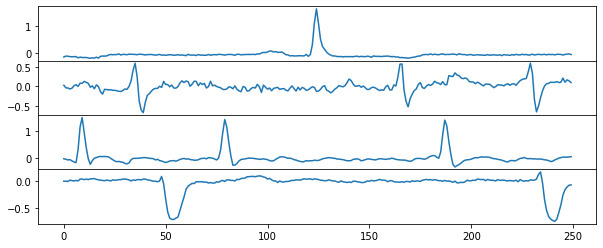

Batch index:  1
Channel 1 shape:  torch.Size([64, 250])
Channel 2 shape:  torch.Size([64, 250])


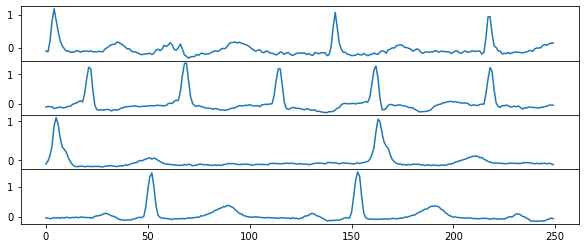

Batch index:  2
Channel 1 shape:  torch.Size([64, 250])
Channel 2 shape:  torch.Size([64, 250])


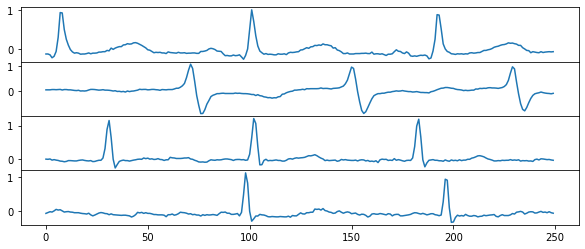

Batch index:  3
Channel 1 shape:  torch.Size([64, 250])
Channel 2 shape:  torch.Size([64, 250])


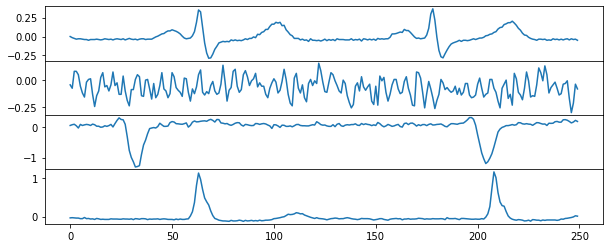

Batch index:  4
Channel 1 shape:  torch.Size([64, 250])
Channel 2 shape:  torch.Size([64, 250])


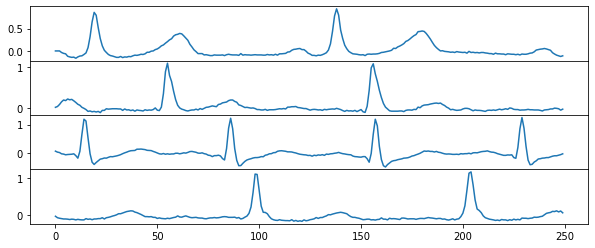

Batch index:  5
Channel 1 shape:  torch.Size([64, 250])
Channel 2 shape:  torch.Size([64, 250])


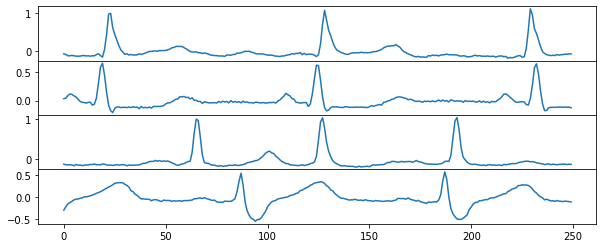

Batch index:  6
Channel 1 shape:  torch.Size([64, 250])
Channel 2 shape:  torch.Size([64, 250])


KeyboardInterrupt: 

In [7]:
print("Validation dataset size: ", len(dataset))
print("Validation dataloader size: ", len(dataloader))

for i, (channel1, channel2) in enumerate(dataloader):
    print("Batch index: ", i)
    print("Channel 1 shape: ", channel1.shape)
    print("Channel 2 shape: ", channel2.shape)

    fig, axes = plt.subplots(
    nrows=4,
    ncols=1,
    figsize=[10, 4],
    gridspec_kw={ "hspace": 0 },
    )
    for j in range(4):
        axes[j].plot(channel1[j], label="Channel 1")
        # axes[j].plot(channel2[j], label="Channel 2")
        # axes[j].legend()
    plt.show()
    


The chart above shows what we should expect from the signals generated by our generator.

Now for statistical analysis:

In [9]:
chanel1_stats = {
    "std": [],
    "mean": [],
    "max": [],
    "min": [],
}
chanel2_stats = {
    "std": [],
    "mean": [],
    "max": [],
    "min": [],
}

for i, (channel1, channel2) in enumerate(dataloader):
    chanel1_stats["std"].append(channel1.std())
    chanel1_stats["mean"].append(channel1.mean())
    chanel1_stats["max"].append(channel1.max())
    chanel1_stats["min"].append(channel1.min())

    chanel2_stats["std"].append(channel2.std())
    chanel2_stats["mean"].append(channel2.mean())
    chanel2_stats["max"].append(channel2.max())
    chanel2_stats["min"].append(channel2.min())

In [10]:
print(f"channel 0 global min: {min(chanel1_stats['min'])}")
print(f"channel 0 global max: {max(chanel1_stats['max'])}")

print(f"channel 1 global min: {min(chanel2_stats['min'])}")
print(f"channel 1 global max: {max(chanel2_stats['max'])}")

channel 0 global min: -10.515237808227539
channel 0 global max: 9.494109153747559
channel 1 global min: -7.820725917816162
channel 1 global max: 7.599456787109375


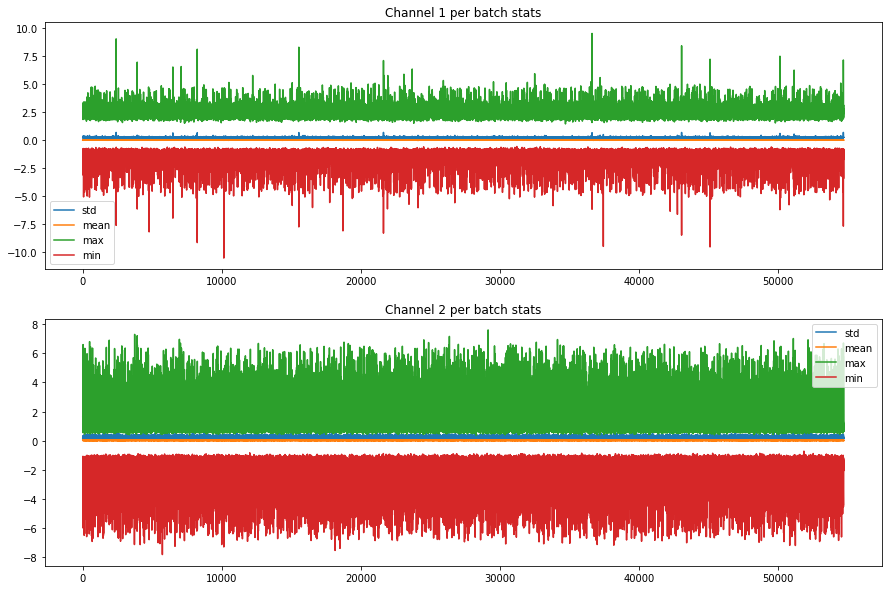

In [11]:
# Plot the statistics
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
axs[0].plot(chanel1_stats["std"], label="std")
axs[0].plot(chanel1_stats["mean"], label="mean")
axs[0].plot(chanel1_stats["max"], label="max")
axs[0].plot(chanel1_stats["min"], label="min")
axs[0].legend()
axs[0].set_title("Channel 1 per batch stats")

axs[1].plot(chanel2_stats["std"], label="std")
axs[1].plot(chanel2_stats["mean"], label="mean")
axs[1].plot(chanel2_stats["max"], label="max")
axs[1].plot(chanel2_stats["min"], label="min")
axs[1].legend()
axs[1].set_title("Channel 2 per batch stats")

plt.show()